In [211]:
import pandas as pd
import yaml
from PIL import Image
import numpy
from torchvision import transforms
import sys
import matplotlib.pyplot as plt
import plotnine as pl
import seaborn as sns
# import math
import textwrap
from tqdm import tqdm

sys.path.append('../')

from train import create_dataloader, load_model
from dataset import MDclassDataset

import torch

split_name = "frac1.0_split0.3"
config_name = "resnet18"
run_name = "2025-01-23_00-11-13_resnet18_100e_256bs_0.0001lr_0.0wd_frac1.0_split0.3"
model_name = "resnet18"
!pwd

/home/Vale/Documents/cv4e/CV4E-2025/mdclassifier


In [212]:
dat_train = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_train.csv")
dat_val = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_val.csv")
dat_test = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_test.csv")

lookup = pd.read_csv("~/Documents/cv4e/CV4E-2025/data/tabular/labels_lookup.csv")
cfg = yaml.safe_load(open(f"../runs/{run_name}/{run_name}_config.yaml", "r"))

In [213]:
dat_train

crop_path label_spe  \
0      cropped/animal/TC1_P028_P028-1_WLU-10_100_0152...   Caribou   
1      cropped/animal/TC1_P028_P028-1_WLU-10_100_0153...   Caribou   
2      cropped/animal/TC1_P028_P028-1_WLU-10_100_0154...   Caribou   
3      cropped/animal/TC1_P028_P028-1_WLU-10_100_0155...   Caribou   
4      cropped/animal/TC1_P028_P028-1_WLU-10_100_0156...   Caribou   
...                                                  ...       ...   
87920  cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...   Vehicle   
87921  cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...   Vehicle   
87922  cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...   Vehicle   
87923  cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...   Vehicle   
87924  cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...   Vehicle   

       confidence   conf                                         meta_split  \
0             NaN  1.000  ['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...   
1             NaN  1.000  ['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...   
2             NaN  1.000  ['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...   
3             NaN  1.000  ['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...   
4             NaN  1.000  ['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...   
...           ...    ...                                                ...   
87920       0.823  0.823  ['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...   
87921       0.823  0.823  ['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...   
87922       0.828  0.828  ['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...   
87923       0.827  0.827  ['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...   
87924       0.773  0.773  ['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...   

      dep_id loc_id  sit_id  cam_id label_group label_group_bin   size  \
0        TC1   P028  P028-1  WLU-10        CARI            ANIM  15334   
1        TC1   P028  P028-1  WLU-10        CARI            ANIM  15334   
2        TC1   P028  P028-1  WLU-10        CARI            ANIM  15334   
3        TC1   P028  P028-1  WLU-10        CARI            ANIM  15334   
4        TC1   P028  P028-1  WLU-10        CARI            ANIM  15334   
...      ...    ...     ...     ...         ...             ...    ...   
87920    TC3   P427  P427-3  WLU-64        VEHI            NONE    607   
87921    TC3   P427  P427-3  WLU-64        VEHI            NONE    607   
87922    TC3   P427  P427-3  WLU-64        VEHI            NONE    607   
87923    TC3   P427  P427-3  WLU-64        VEHI            NONE    607   
87924    TC3   P427  P427-3  WLU-64        VEHI            NONE    607   

       label_id  label_id_bin  
0             2             1  
1             2             1  
2             2             1  
3             2             1  
4             2             1  
...         ...           ...  
87920        12             0  
87921        12             0  
87922        12             0  
87923        12             0  
87924        12             0  

[87925 rows x 14 columns]

In [186]:
dat_train[["label_group_bin", "label_id_bin"]].drop_duplicates()
# len(dat_test.label_id.unique())
dat_val.shape
dat_train.label_id_bin
dat_val[["label_group_bin", "label_id_bin"]].drop_duplicates()
n_class = dat_train.label_id_bin.nunique()
n_class

2

In [187]:
list(1/(dat_train.label_id_bin.value_counts()/max(dat_train.label_id_bin.value_counts())))

[1.0, 1.5578925932390761]

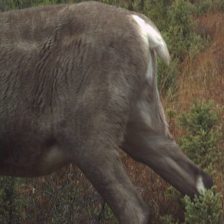

In [188]:
dl_train = create_dataloader(cfg, dat_train.crop_path, dat_train.label_id_bin)
dl_val = create_dataloader(cfg, dat_val.crop_path, dat_val.label_id_bin)
instance=next(iter(dl_train))
ims = [instance["image"][x] for x in range(len(instance["image"]))]
labs = [instance["label"][x] for x in range(len(instance["label"]))]
labs = [lookup.query(f'label_id == {x}').iloc[0,0] for x in [x.numpy() for x in labs]]
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

ims = [invTrans(ims[x]) for x in range(len(ims))]
Image.fromarray((255*numpy.transpose(ims[0].numpy(), (1,2,0))).astype(numpy.uint8))
ims_pil = [Image.fromarray((255*numpy.transpose(ims[x].numpy(), (1,2,0))).astype(numpy.uint8)) for x in range(len(ims))]
ims_pil[0]

In [189]:
def display_images(
    images, labs,
    columns=5, width=20, height=8, max_images=1000000, 
    label_wrap_length=50, label_font_size=30):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        title=textwrap.wrap(labs[i], label_wrap_length)
        title="\n".join(title)
        plt.title(title, fontsize=label_font_size); 

# display_images(ims_pil, labs)

In [190]:
state = torch.load(
            open(f"/home/Vale/Documents/cv4e/CV4E-2025/runs/{run_name}/best.pt", "rb"), map_location="cpu", 
            weights_only=True
        )
state["epoch"]

100

In [191]:
state["model"]

OrderedDict([('feature_extractor.conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
              

In [192]:
model = load_model(cfg, n_class-1)[0]

Starting new model


In [193]:
model.load_state_dict(state["model"])
# model

<All keys matched successfully>

In [194]:
preds = model(instance["image"])
preds

preds_id = list(preds.argmax(axis=1).numpy())
preds_id[0:10]
preds_labs = [lookup.at[x, 'label_group'] for x in preds_id]
preds_labs[0:10]
truth_preds_labs = ["T:" + x + " - " + "P:" + y for x, y in zip(labs, preds_labs)]
truth_preds_labs[0:10]

# display_images(ims_pil, truth_preds_labs, label_font_size=15)

['T:STAF - P:NONE',
 'T:STAF - P:NONE',
 'T:NONE - P:NONE',
 'T:STAF - P:NONE',
 'T:NONE - P:NONE',
 'T:NONE - P:NONE',
 'T:NONE - P:NONE',
 'T:NONE - P:NONE',
 'T:STAF - P:NONE',
 'T:NONE - P:NONE']

In [195]:
instance=next(iter(dl_val))
ims = [instance["image"][x] for x in range(len(instance["image"]))]
labs = [instance["label"][x] for x in range(len(instance["label"]))]
labs = [lookup.query(f'label_id == {x}').iloc[0,0] for x in [x.numpy() for x in labs]]
ims = [invTrans(ims[x]) for x in range(len(ims))]
ims_pil = [Image.fromarray((255*numpy.transpose(ims[x].numpy(), (1,2,0))).astype(numpy.uint8)) for x in range(len(ims))]
preds = model(instance["image"])
preds_id = list(preds.argmax(axis=1).numpy())
preds_labs = [lookup.at[x, 'label_group'] for x in preds_id]
true_preds_labs = ["T:" + x + " - " + "P:" + y for x, y in zip(labs, preds_labs)]

# display_images(ims_pil, true_preds_labs, label_font_size=15)

In [196]:
device = "cuda"
all_predictions = []
all_labels = []
all_image_paths = []
model.eval()
model.to(device)
with torch.no_grad():
    for batch_n, batch in tqdm(enumerate(dl_train), total = len(dl_train)):
        # put data and labels on device
        data, labels, image_paths = batch["image"].to(device), batch["label"].to(device), batch["image_path"]
        
        # forward pass
        all_predictions.extend(model(data).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_image_paths.extend(image_paths)
        

100%|██████████| 344/344 [00:57<00:00,  6.00it/s]


In [197]:
all_image_paths

['/mnt/class_data/group4/val/trailcam/cropped/empty/TC1_P045_P045-1b_WLU-03_101_7026_2022_06_17_18_10_34_bbx1_prediction_animal_sp_NONE_VNA_VNA.JPEG',
 '/mnt/class_data/group4/val/trailcam/cropped/animal/TC3_P427_P427-4_CFS-03_100_W_0601_2022_11_01_12_35_06_bbx1_prediction_animal_sp_Caribou_Adult_Unkn.JPEG',
 '/mnt/class_data/group4/val/trailcam/cropped/animal/TC3_P498_P498-2_WLU-89_100_W_1012_2022_08_22_19_25_15_bbx1_prediction_animal_sp_Caribou_Adult_Male.JPEG',
 '/mnt/class_data/group4/val/trailcam/cropped/staff/TC1_Q619_Q619-3_WLU-182_100_0805_2022_09_11_15_20_48_bbx1_prediction_person_sp_STAFF_VNA_VNA.JPEG',
 '/mnt/class_data/group4/val/trailcam/cropped/animal/TC1_P062_P062-1_WLU-47_100_0920_2022_05_03_15_43_13_bbx4_prediction_animal_sp_Canada_Goose_Adult_Unkn.JPEG',
 '/mnt/class_data/group4/val/trailcam/cropped/animal/TC1_P059_P059-4_WLU-01_100_0840_2022_06_21_20_19_01_bbx1_prediction_animal_sp_Sandhill_Crane_Adult_Unkn.JPEG',
 '/mnt/class_data/group4/val/trailcam/cropped/empty/T

In [198]:
all_predictions

[array([-2.5443633], dtype=float32),
 array([5.1148477], dtype=float32),
 array([4.0703826], dtype=float32),
 array([-3.2744], dtype=float32),
 array([3.2722406], dtype=float32),
 array([1.2498599], dtype=float32),
 array([-1.9207596], dtype=float32),
 array([-0.6465692], dtype=float32),
 array([-4.7079153], dtype=float32),
 array([-0.5982221], dtype=float32),
 array([0.24943888], dtype=float32),
 array([3.3917816], dtype=float32),
 array([-2.333992], dtype=float32),
 array([0.8814998], dtype=float32),
 array([0.82070494], dtype=float32),
 array([-3.682696], dtype=float32),
 array([1.2554001], dtype=float32),
 array([0.15271848], dtype=float32),
 array([-1.2776787], dtype=float32),
 array([-4.22015], dtype=float32),
 array([3.6201298], dtype=float32),
 array([-1.4382972], dtype=float32),
 array([1.3873988], dtype=float32),
 array([-2.700924], dtype=float32),
 array([-3.3113854], dtype=float32),
 array([1.361376], dtype=float32),
 array([-1.4824904], dtype=float32),
 array([-1.3282882],

Categoies

In [14]:
# softmax = torch.logit(torch.softmax(torch.tensor(all_predictions), dim =1))
# preds = pd.DataFrame(softmax, columns=lookup.label_group).assign(label_id=all_labels).merge(lookup).drop(["label_id", "size"], axis=1)
# preds.to_csv("../outputs/predictions.csv")

/tmp/ipykernel_439869/4126068266.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/torch/csrc/utils/tensor_new.cpp:278.)


In [199]:
lookup

label_group label_group_bin   size  label_id  label_id_bin
0         NONE            NONE  52128         0             0
1         STAF            NONE  26961         1             0
2         CARI            ANIM  15334         2             1
3         GOOS            ANIM   7068         3             1
4         DUCK            ANIM   6697         4             1
5         MOOS            ANIM   6465         5             1
6         SAND            ANIM   4865         6             1
7         BIRD            ANIM   3223         7             1
8         GROU            ANIM   2801         8             1
9         MAMM            ANIM   1645         9             1
10        BEAR            ANIM   1192        10             1
11        MUST            ANIM    914        11             1
12        VEHI            NONE    607        12             0

Binary

In [200]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [201]:
preds = pd.DataFrame(all_predictions, columns=["score"]).assign(label_id=all_labels)
preds["image_path"] = all_image_paths
preds["sig_score"] = [sigmoid(x) for x in preds.score]
preds["label_group"] = ["NONE" if x == 0 else "ANIM" for x in preds.label_id]
preds["pred_label"] = ["NONE" if x<0 else "ANIM" for x in preds.score]
preds["result"] = [True if x == y else False for x,y, in zip(preds.label_group, preds.pred_label)]
preds["sig_score_str"] = [str(round(x,2)) for x in preds.sig_score]
preds

score  label_id                                         image_path  \
0     -2.544363         0  /mnt/class_data/group4/val/trailcam/cropped/em...   
1      5.114848         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
2      4.070383         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
3     -3.274400         0  /mnt/class_data/group4/val/trailcam/cropped/st...   
4      3.272241         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
...         ...       ...                                                ...   
87920 -2.445656         0  /mnt/class_data/group4/val/trailcam/cropped/em...   
87921 -1.759140         0  /mnt/class_data/group4/val/trailcam/cropped/em...   
87922 -3.832704         0  /mnt/class_data/group4/val/trailcam/cropped/st...   
87923 -3.919346         0  /mnt/class_data/group4/val/trailcam/cropped/st...   
87924  0.650311         0  /mnt/class_data/group4/val/trailcam/cropped/em...   

       sig_score label_group pred_label  result sig_score_str  
0       0.072806        NONE       NONE    True          0.07  
1       0.994029        ANIM       ANIM    True          0.99  
2       0.983216        ANIM       ANIM    True          0.98  
3       0.036460        NONE       NONE    True          0.04  
4       0.963464        ANIM       ANIM    True          0.96  
...          ...         ...        ...     ...           ...  
87920   0.079757        NONE       NONE    True          0.08  
87921   0.146898        NONE       NONE    True          0.15  
87922   0.021192        NONE       NONE    True          0.02  
87923   0.019468        NONE       NONE    True          0.02  
87924   0.657081        NONE       ANIM   False          0.66  

[87925 rows x 8 columns]

In [202]:
preds.to_csv("../outputs/predictions.csv")

In [203]:
preds.pred_label.value_counts()

pred_label
NONE    57029
ANIM    30896
Name: count, dtype: int64

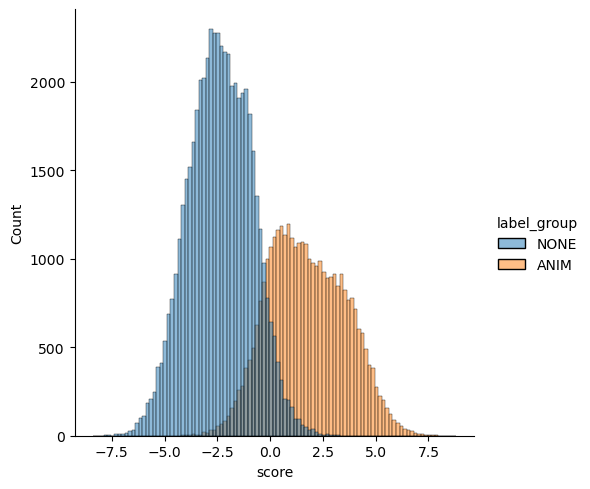

In [204]:
import seaborn as sns
import numpy as np

sns.displot(data=preds, x="score", hue = "label_group")

In [205]:
def display_subset(preds, cls, thresh_exp, size, cfg):
    subset = preds.query(f"label_group == '{cls}'").query(f"sig_score {thresh_exp}")
    print(f"subset is of shape {subset.shape}")
    images = [Image.open(x).resize((cfg["image_size"], cfg["image_size"])) for x in subset.image_path[0:size]]
    display_images(images, list(subset.sig_score_str)[0:size])
    return subset, images

subset is of shape (2211, 8)


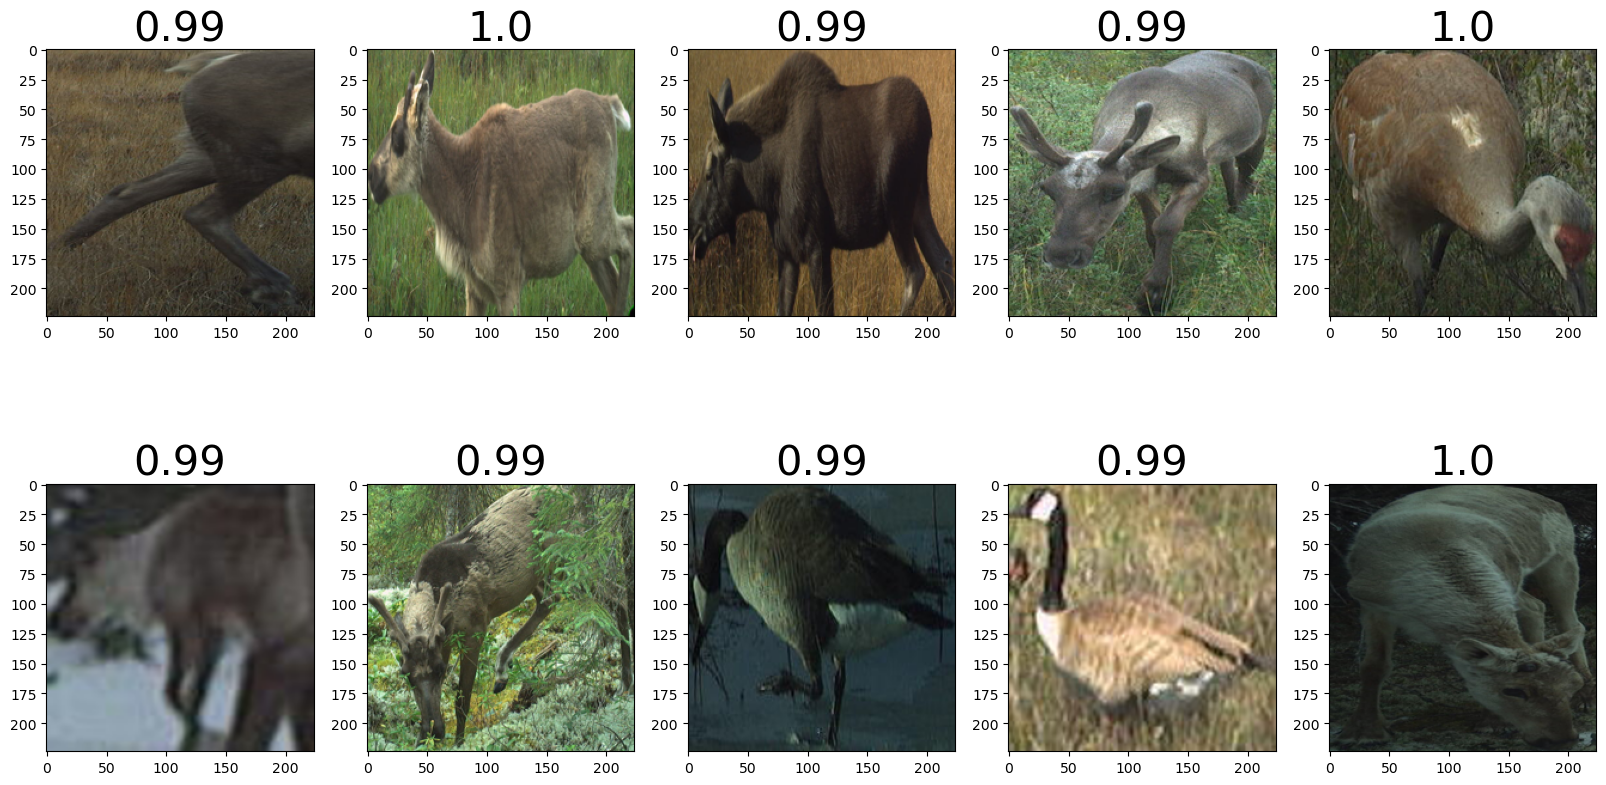

In [206]:

sub, sub_img =display_subset(preds, "ANIM", "> 0.99", 10, cfg)

In [207]:
list(sub.image_path)[0]

'/mnt/class_data/group4/val/trailcam/cropped/animal/TC3_P427_P427-4_CFS-03_100_W_0601_2022_11_01_12_35_06_bbx1_prediction_animal_sp_Caribou_Adult_Unkn.JPEG'

subset is of shape (59, 8)


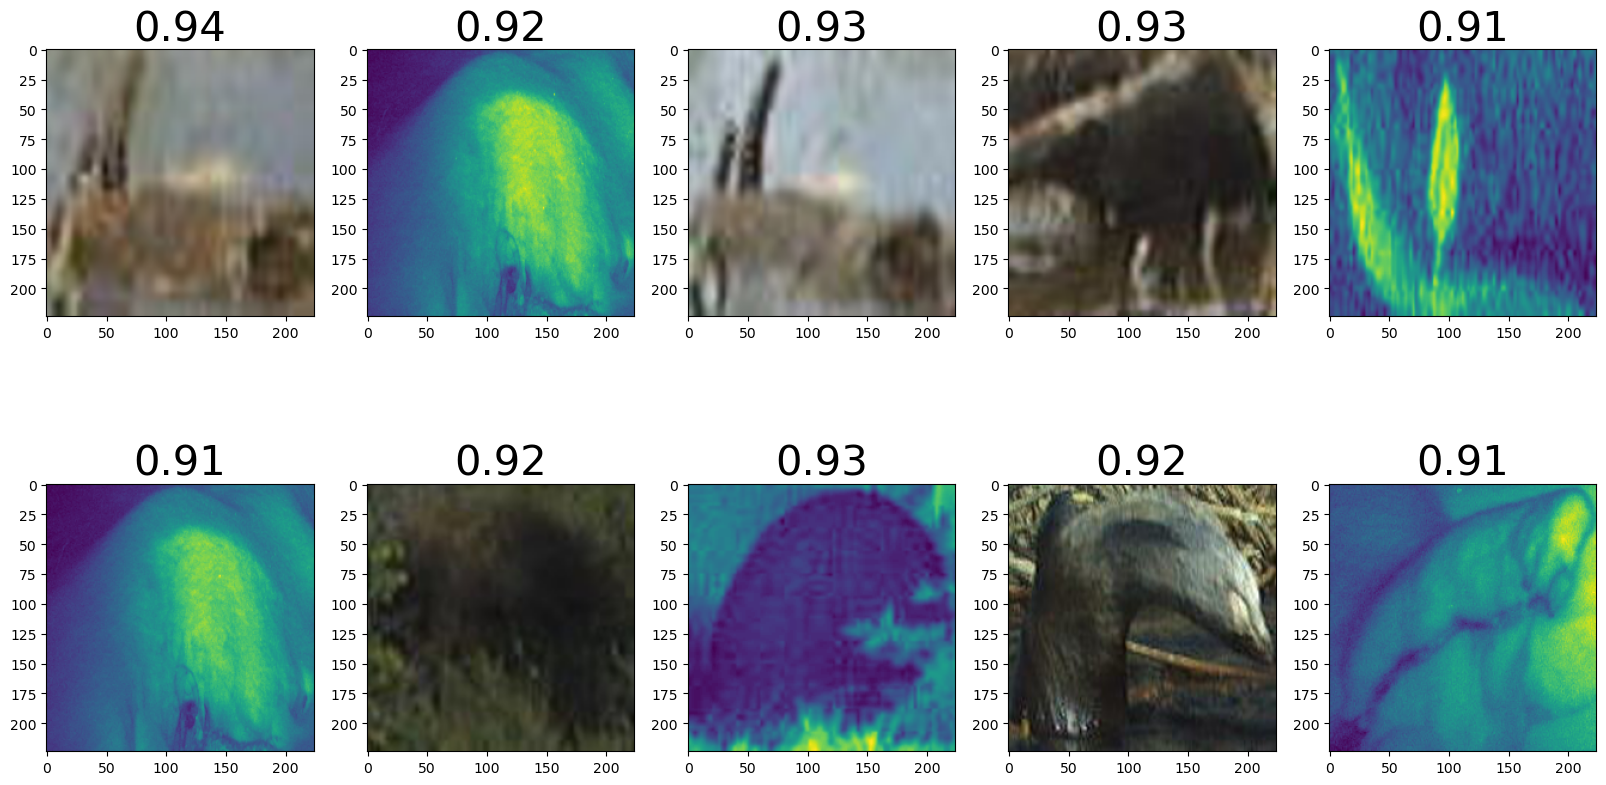

In [209]:
sub, sub_img = display_subset(preds, "NONE", "> 0.90", 10, cfg)

In [164]:
list(sub.image_path)[0]

'/mnt/class_data/group4/val/trailcam/cropped/animal/TC2_INTC06_INTC06-1_CWS-ON100_W_0071_2022_10_20_15_16_17_bbx9_prediction_animal_sp_MD.JPEG'

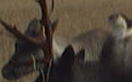

In [179]:
i = "/mnt/class_data/group4/val/trailcam/cropped/animal/TC2_INTC06_INTC06-1_CWS-ON100_W_0071_2022_10_20_15_16_17_bbx9_prediction_animal_sp_MD.JPEG"
Image.open(i)

subset is of shape (108, 8)


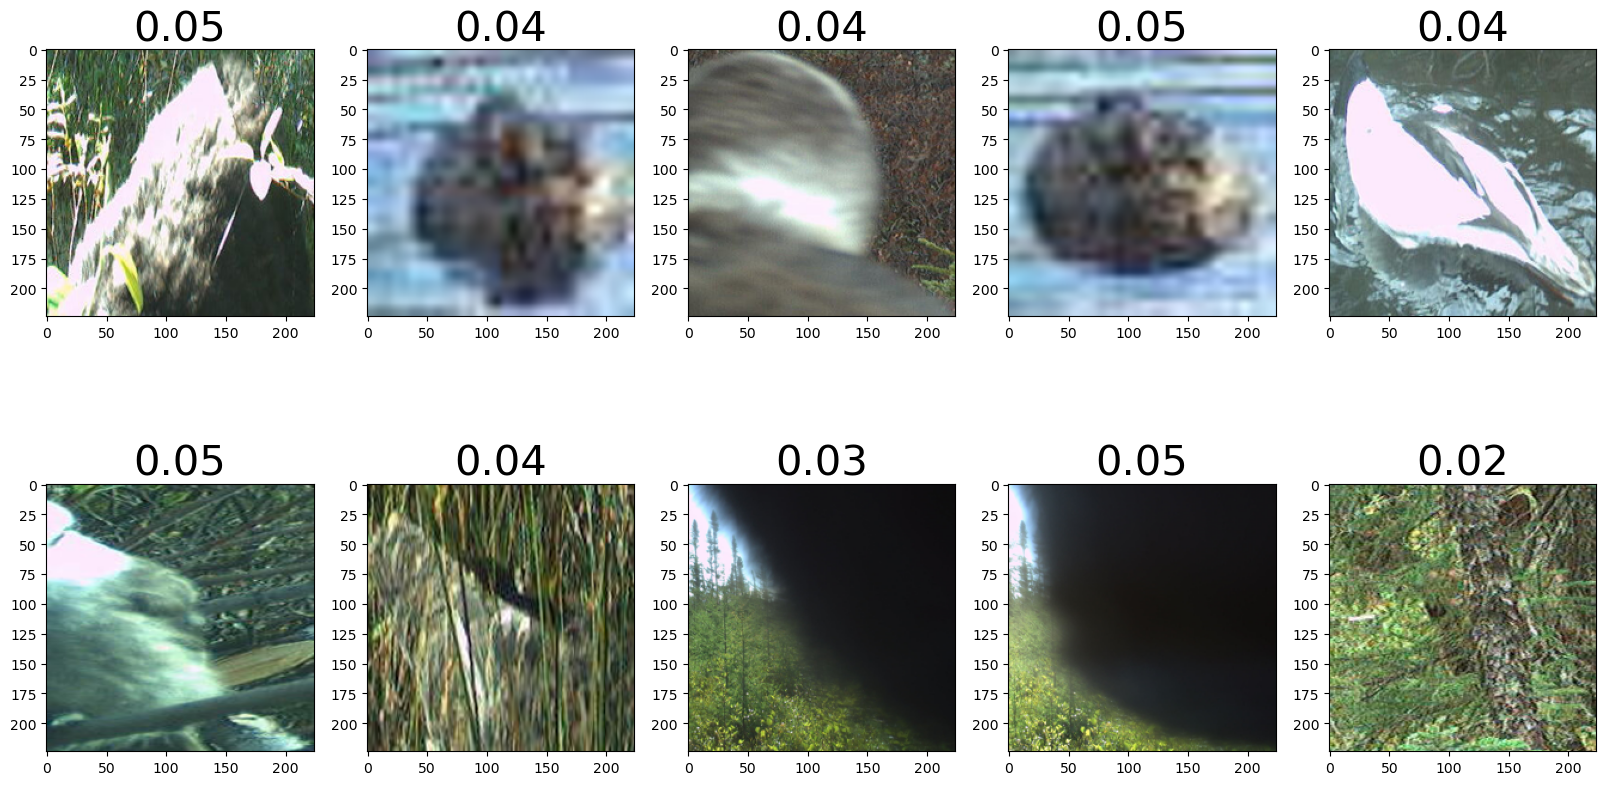

In [166]:
sub, sub_img = display_subset(preds, "ANIM", "< 0.05", 10, cfg)

In [167]:
list(sub.image_path)[0]

'/mnt/class_data/group4/val/trailcam/cropped/animal/TC1_P363_P363-2_WLU-162_100_0331_2022_06_24_18_00_28_bbx1_prediction_animal_sp_American_Black_Bear_Adult_Unkn.JPEG'

subset is of shape (22596, 8)


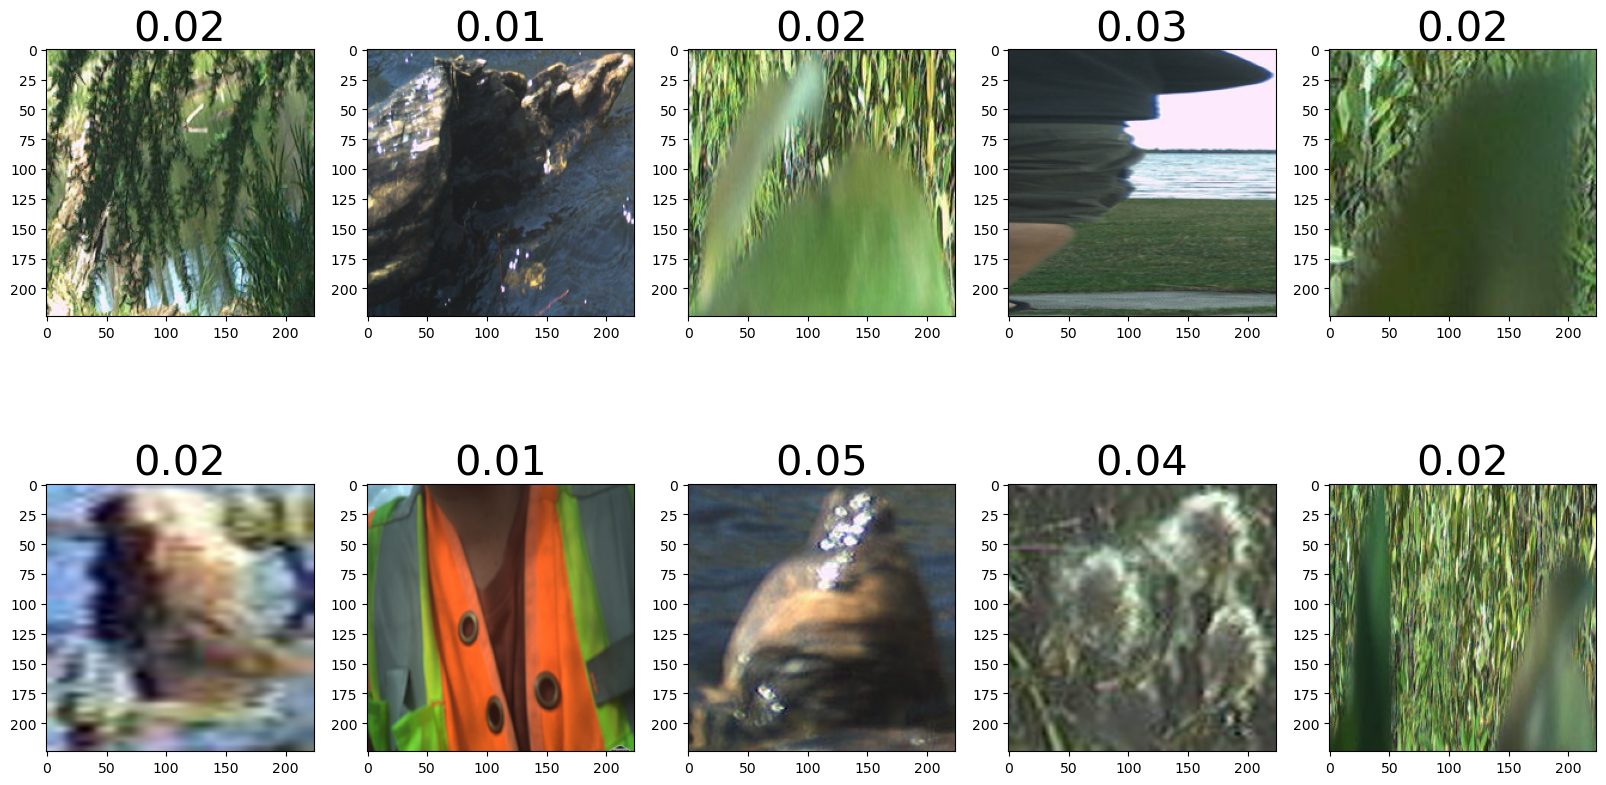

In [168]:
sub, sub_img = display_subset(preds, "NONE", "< 0.05", 10, cfg)

In [170]:
list(sub.image_path)[0]

'/mnt/class_data/group4/val/trailcam/cropped/empty/TC1_P045_P045-1b_WLU-03_102_0225_2022_06_18_12_42_29_bbx1_prediction_animal_sp_NONE_VNA_VNA.JPEG'

In [169]:
# Calculate logits

# df["logits"] = np.log(df["conf"] / (1 - df["conf"]))

# Classify as positive or negative
df = preds
# df["label"] = np.where(df["pred"] == df["true"], "Positive", "Negative")

# choose class
chosen_class = "ANIM"
filtered_df = df[df["label_group"] == chosen_class]

# Plot histogram for the first class
# plt.figure(figsize=(8, 6))
# sns.histplot(data=preds, x="score", hue="result", kde=True, bins=100)
# plt.title(f"Logit Distribution for Class {chosen_class}")
# plt.xlabel("Logits")
# plt.ylabel("Frequency")
# plt.show()

# # Plot histogram for the first class
# plt.figure(figsize=(8, 6))
# sns.histplot(data=filtered_df, x="sig_score", hue="result", kde=True, bins=100)
# plt.title(f"Confidence Distribution for Class {chosen_class}")
# plt.xlabel("Confidence")
# plt.ylabel("Frequency")
# plt.show()

In [50]:
filtered_df

score  label_id                                         image_path  \
2      2.581120         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
3     -3.047215         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
10     0.430593         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
11     1.125671         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
12     3.638601         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
...         ...       ...                                                ...   
99414  4.194087         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
99415  1.034139         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
99417  3.498200         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
99419  1.472626         1  /mnt/class_data/group4/val/trailcam/cropped/an...   
99421  1.357812         1  /mnt/class_data/group4/val/trailcam/cropped/an...   

       sig_score label_group pred_label  result  
2       0.929637        ANIM       ANIM    True  
3       0.045338        ANIM       NONE   False  
10      0.606015        ANIM       ANIM    True  
11      0.755039        ANIM       ANIM    True  
12      0.974384        ANIM       ANIM    True  
...          ...         ...        ...     ...  
99414   0.985140        ANIM       ANIM    True  
99415   0.737717        ANIM       ANIM    True  
99417   0.970637        ANIM       ANIM    True  
99419   0.813456        ANIM       ANIM    True  
99421   0.795404        ANIM       ANIM    True  

[35722 rows x 7 columns]

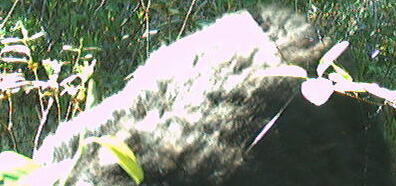

In [181]:
img = filtered_df.iloc[1, 2]
img_obj = Image.open(img)
img_obj